# Benchmark Analysis - H8

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import os
from pathlib import Path
from typing import List, Dict, Any, Tuple

%matplotlib inline

In [3]:
matplotlib.style.use('seaborn-v0_8')  

In [4]:
root_dir = '/Users/diego/Desktop/BENCHMARK_HYDRA_CPU_67M_WITH_BYTES'

In [5]:
GCC_TBB_COLOR = 'salmon'
GCC_TBB_COLOR_SECONDARY = 'sienna'

NVC_OMP_COLOR = 'green'
NVC_OMP_COLOR_SECONDARY = 'yellowgreen'

NVC_GPU_COLOR = 'beige'


In [6]:
plot_save_dir = './plots/h8'

## Utils 

In [7]:
def get_path(*entries):
    return os.path.join(*entries)

In [8]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [9]:
def plot(name:str,save=True) -> None:
    name = name.replace(' ','-')
    if save:
        plt.savefig(get_path(plot_save_dir,name+".png"),bbox_inches='tight')
    plt.show()

In [10]:
def extraction_pandas_frame_algo(path, COMP="TODO"):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = COMP
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


In [11]:
# generate filename for threading
def get_threading_file_name(benchmark_name:str, thread_nr: int, input_size:str) -> str:
    return f"[T{thread_nr}]_{benchmark_name}_{input_size}_T{thread_nr}.csv"

# extract threaded into dictionary
def extraction_pandas_frame_algo_threaded(folder_path:str, benchmark_name:str, threads_list:List[int], input_size:int = '67108864', COMP:str="TODO") -> Any:
    result = pd.DataFrame()

    for t_id in threads_list:
        filename = get_threading_file_name(benchmark_name=benchmark_name,thread_nr=t_id,input_size=input_size)
        file_path = get_path(folder_path,filename)
        
        data_frame = extraction_pandas_frame_algo(file_path,COMP=COMP)
        data_frame['threads'] = t_id
        result = pd.concat([result, data_frame], ignore_index=True)


    result = result.rename_axis(None, axis=1)
    return result

In [12]:
# calculate speedup based on seq runnings
def calc_speedup_based_seq(seq_df: pd.DataFrame, threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    # calculate speedup
    seq_df = seq_df[seq_df['n'] == input_size]
    seq_time = seq_df['real_time'].iloc[0] # now its only a single digit

    threads_df['speedup'] = seq_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [13]:
def calc_speedup_based_par(threads_df: pd.DataFrame, speedup_column_name:str, input_size:int = 67108864) -> pd.DataFrame:
    base_time = threads_df[threads_df['threads'] == 1].iloc[0]['real_time']
    
    threads_df['speedup'] = base_time / threads_df['real_time'] 

    # clean df
    threads_df = threads_df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler','n','real_time'])
    threads_df = threads_df.rename(columns={'speedup':speedup_column_name})

    return threads_df

In [14]:
def par_data_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    # load bench_name
    df = extraction_pandas_frame_algo(root_dir + f'/{compiler_location}/DEFAULT/{bench_name}_par__Default.csv',COMP=compiler_name)

    df = df.drop(columns=['name','cpu_time','time_unit','median','stddev','Compiler'])
    df = df.rename(columns={'real_time':f'{compiler_name}'})

    return df

In [15]:
def get_strong_scaling_algo(compiler_location:str,compiler_name:str,bench_name:str) -> pd.DataFrame:
    
    ## seq base
    seq_base = extraction_pandas_frame_algo(f'{root_dir}/{compiler_location}/DEFAULT/{bench_name}_seq__Default.csv',
                                            COMP=compiler_name)
    
    ## threaded
    df = extraction_pandas_frame_algo_threaded(f'{root_dir}/{compiler_location}/THREADS',
                                               f'{bench_name}_par',
                                               [1,2,4,8,16,32],
                                               COMP=compiler_name
                                               )

    ## calc strong scaling
    return calc_speedup_based_seq(seq_base,df,f"{compiler_name}")

# H8

> Parallel STL does not inherently provide support for index-based iterations, thereby requiring the developer to devise
> a custom sequence for indices. The manner in which the index values are generated by the developer can significantly
> impact the application's performance and scalability.

## `b9_1_transform_baseline`

In [16]:
benchmark_name = "b9_1_transform_baseline"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_1_transform_baseline`

Check how the runtime without constraining the threads develops with increasing input size

In [17]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_1_transform_baseline_time_merged = pd.merge(*data, on='n')

b9_1_transform_baseline_time_merged

,GCC(TBB),n,NVC(OMP)
0,3776.37,4,6873.10
1,5707.52,8,6868.52
2,9175.38,16,7117.76
3,13949.80,32,7743.06
4,18302.30,64,7613.48
5,22364.60,128,7877.21
6,25703.60,256,7557.88
7,29908.10,512,7702.86
8,33480.60,1024,7593.58
9,36027.10,2048,7653.00


### Strong Scaling - `b9_1_transform_baseline`
 
2^26 fixed input size with threads 1-64

In [18]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_1_transform_baseline_strong_scaling_merged = pd.merge(*data, on='threads')

b9_1_transform_baseline_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.026553,0.845210
1,2,1.991469,1.658070
2,4,3.276072,3.192445
3,8,4.276538,4.688972
4,16,3.986734,5.875815
5,32,3.156298,4.090156


In [19]:
## efficiency graph

b9_1_transform_baseline_efficiency = b9_1_transform_baseline_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_1_transform_baseline_efficiency[f'{compiler_name}'] = b9_1_transform_baseline_efficiency[f'{compiler_name}'] / b9_1_transform_baseline_efficiency['threads']



b9_1_transform_baseline_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.026553,0.845210
1,2,0.995735,0.829035
2,4,0.819018,0.798111
3,8,0.534567,0.586121
4,16,0.249171,0.367238
5,32,0.098634,0.127817


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_42620/3527680241.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


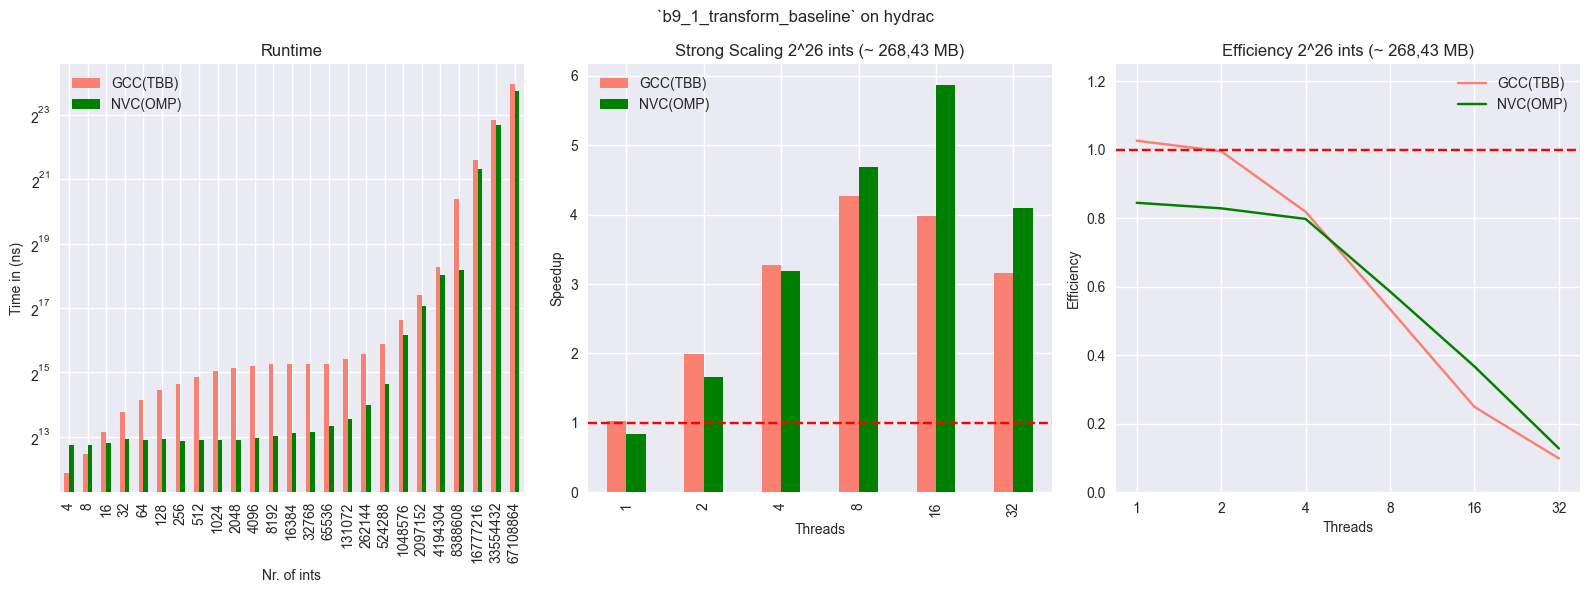

In [20]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_1_transform_baseline_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_1_transform_baseline_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_1_transform_baseline_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b9_1_transform_baseline` on hydrac")

fig.tight_layout()

plot("`b9_1_transform_baseline` hydrac")

## `b9_2_transform_old_iota`

In [21]:
benchmark_name = "b9_2_transform_old_iota"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_2_transform_old_iota`

Check how the runtime without constraining the threads develops with increasing input size

In [22]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_2_transform_old_iota_time_merged = pd.merge(*data, on='n')

b9_2_transform_old_iota_time_merged

,GCC(TBB),n,NVC(OMP)
0,3.921480e+03,4,6.900980e+03
1,5.865120e+03,8,7.145200e+03
2,9.920430e+03,16,7.365580e+03
3,1.444230e+04,32,8.166760e+03
4,1.866370e+04,64,7.859650e+03
5,2.326610e+04,128,7.594180e+03
6,2.748030e+04,256,8.122830e+03
7,3.185040e+04,512,8.845860e+03
8,3.557590e+04,1024,9.532040e+03
9,4.042950e+04,2048,1.290980e+04


### Strong Scaling - `b9_2_transform_old_iota`
 
2^26 fixed input size with threads 1-64

In [23]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_2_transform_old_iota_strong_scaling_merged = pd.merge(*data, on='threads')

b9_2_transform_old_iota_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,0.992132,0.917710
1,2,1.187238,1.113670
2,4,1.298458,1.249907
3,8,1.338209,1.302459
4,16,1.338602,1.335730
5,32,1.274900,1.254932


In [24]:
## efficiency graph

b9_2_transform_old_iota_efficiency = b9_2_transform_old_iota_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_2_transform_old_iota_efficiency[f'{compiler_name}'] = b9_2_transform_old_iota_efficiency[f'{compiler_name}'] / b9_2_transform_old_iota_efficiency['threads']



b9_2_transform_old_iota_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,0.992132,0.917710
1,2,0.593619,0.556835
2,4,0.324615,0.312477
3,8,0.167276,0.162807
4,16,0.083663,0.083483
5,32,0.039841,0.039217


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_42620/21829826.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


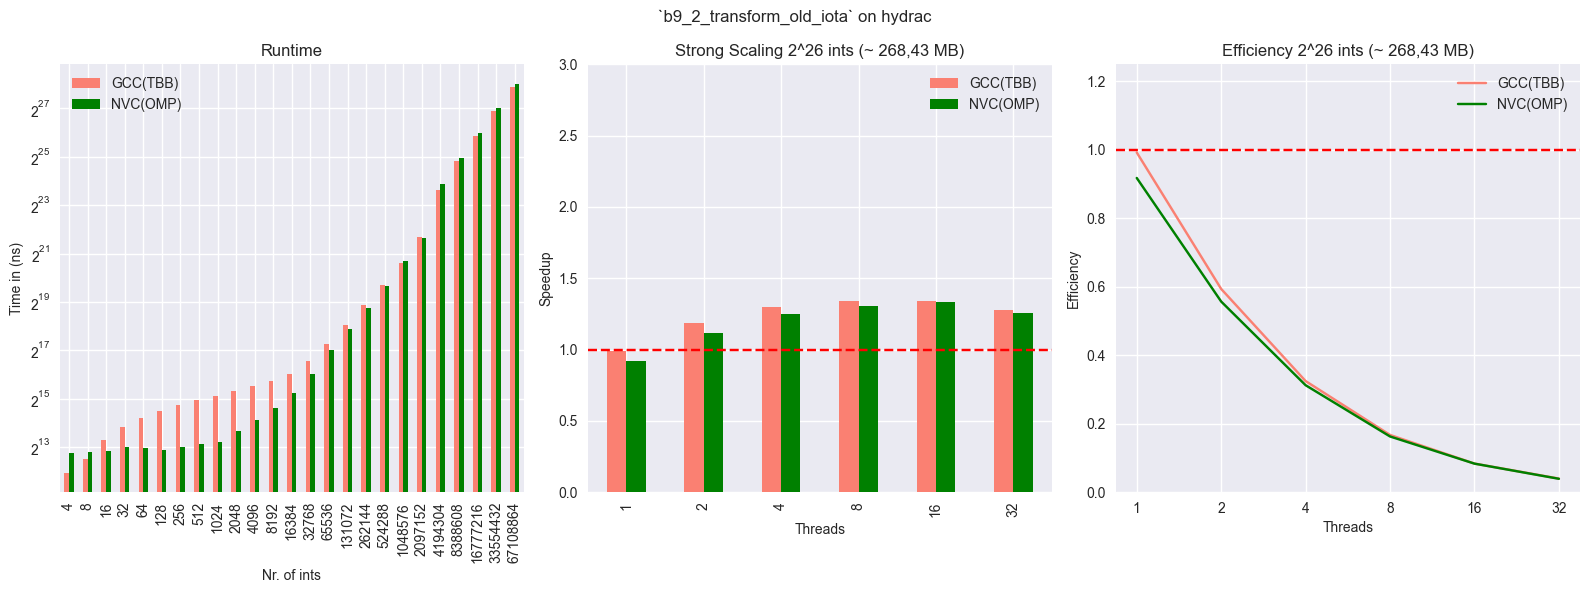

In [25]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_2_transform_old_iota_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_2_transform_old_iota_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_2_transform_old_iota_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b9_2_transform_old_iota` on hydrac")

fig.tight_layout()

plot("`b9_2_transform_old_iota` hydrac")

## `b9_3_transform_views_iota`

In [26]:
benchmark_name = "b9_3_transform_views_iota"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_3_transform_views_iota`

Check how the runtime without constraining the threads develops with increasing input size

In [27]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_3_transform_views_iota_time_merged = pd.merge(*data, on='n')

b9_3_transform_views_iota_time_merged

,GCC(TBB),n,NVC(OMP)
0,1221.82,4,6936.29
1,1223.04,8,7097.53
2,1225.41,16,7096.14
3,1231.43,32,7571.07
4,1243.51,64,7288.72
5,1265.91,128,7630.99
6,1311.91,256,7516.05
7,1415.17,512,7501.15
8,1598.68,1024,7629.50
9,1967.06,2048,7709.01


### Strong Scaling - `b9_3_transform_views_iota`
 
2^26 fixed input size with threads 1-64

In [28]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_3_transform_views_iota_strong_scaling_merged = pd.merge(*data, on='threads')

b9_3_transform_views_iota_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.004100,0.493951
1,2,1.018302,0.984469
2,4,1.023146,1.969193
3,8,1.004726,3.731087
4,16,1.020820,5.983834
5,32,1.023356,4.475555


In [29]:
## efficiency graph

b9_3_transform_views_iota_efficiency = b9_3_transform_views_iota_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_3_transform_views_iota_efficiency[f'{compiler_name}'] = b9_3_transform_views_iota_efficiency[f'{compiler_name}'] / b9_3_transform_views_iota_efficiency['threads']



b9_3_transform_views_iota_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.004100,0.493951
1,2,0.509151,0.492234
2,4,0.255786,0.492298
3,8,0.125591,0.466386
4,16,0.063801,0.373990
5,32,0.031980,0.139861


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_42620/1107526085.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


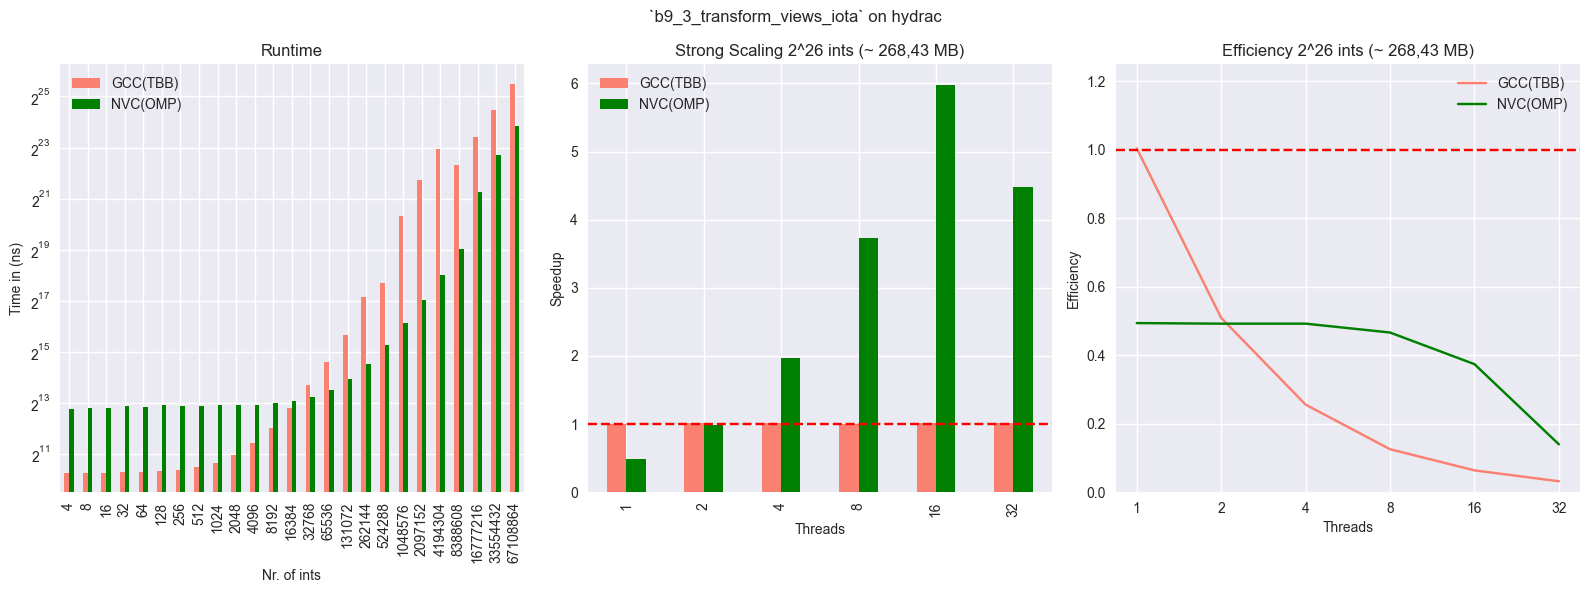

In [30]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_3_transform_views_iota_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_3_transform_views_iota_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_3_transform_views_iota_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b9_3_transform_views_iota` on hydrac")

fig.tight_layout()

plot("`b9_3_transform_views_iota` hydrac")

## `b9_5_transform_custom_iterator`

In [31]:
benchmark_name = "b9_5_transform_custom_iterator"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_5_transform_custom_iterator`

Check how the runtime without constraining the threads develops with increasing input size

In [32]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_5_transform_custom_iterator_time_merged = pd.merge(*data, on='n')

b9_5_transform_custom_iterator_time_merged

,GCC(TBB),n,NVC(OMP)
0,3879.50,4,6955.60
1,5926.57,8,6934.11
2,10002.60,16,6952.25
3,14743.80,32,7666.20
4,19076.90,64,7066.56
5,22884.70,128,7193.80
6,25757.80,256,7111.19
7,28676.50,512,7255.12
8,32021.60,1024,7212.57
9,35523.70,2048,7267.14


### Strong Scaling - `b9_5_transform_custom_iterator`
 
2^26 fixed input size with threads 1-64

In [33]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_5_transform_custom_iterator_strong_scaling_merged = pd.merge(*data, on='threads')

b9_5_transform_custom_iterator_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.011177,0.639915
1,2,2.044148,1.264352
2,4,3.278789,2.510394
3,8,3.975645,4.543688
4,16,3.542204,6.160145
5,32,2.966090,4.361970


In [34]:
## efficiency graph

b9_5_transform_custom_iterator_efficiency = b9_5_transform_custom_iterator_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_5_transform_custom_iterator_efficiency[f'{compiler_name}'] = b9_5_transform_custom_iterator_efficiency[f'{compiler_name}'] / b9_5_transform_custom_iterator_efficiency['threads']



b9_5_transform_custom_iterator_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.011177,0.639915
1,2,1.022074,0.632176
2,4,0.819697,0.627598
3,8,0.496956,0.567961
4,16,0.221388,0.385009
5,32,0.092690,0.136312


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_42620/3445183281.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


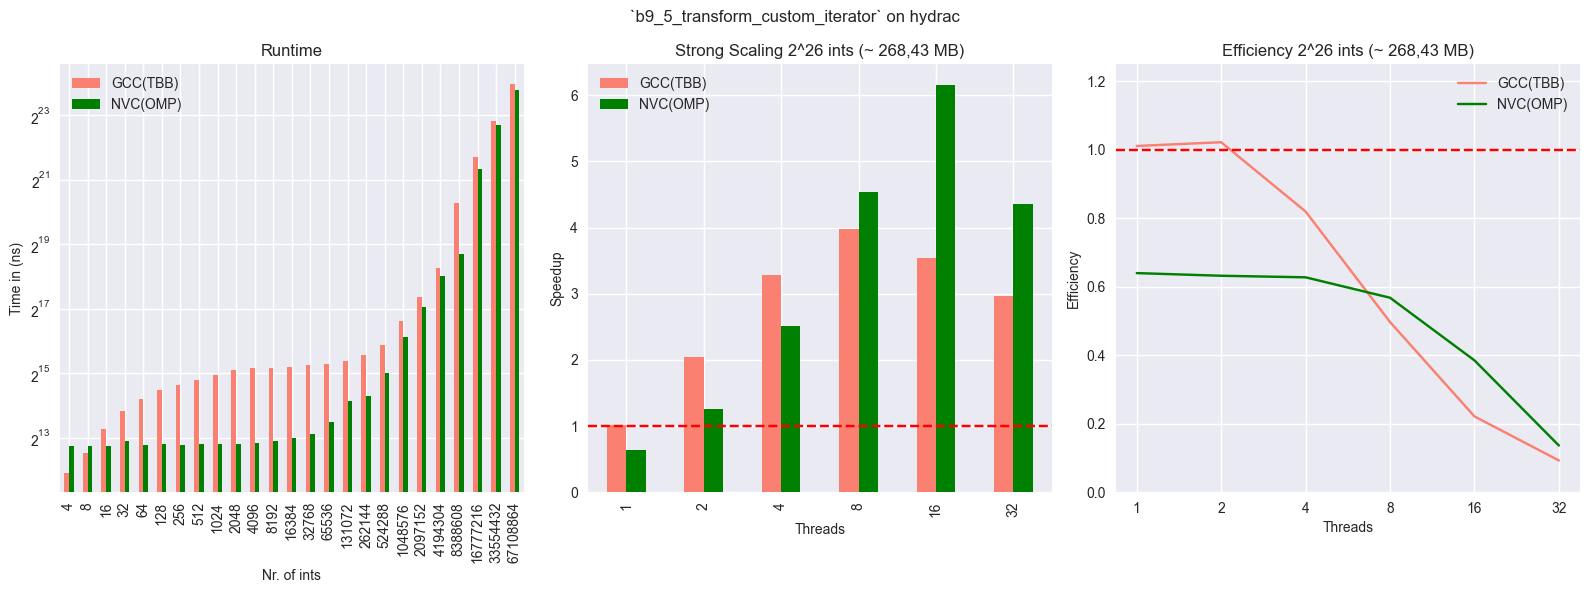

In [35]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_5_transform_custom_iterator_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_5_transform_custom_iterator_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_5_transform_custom_iterator_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b9_5_transform_custom_iterator` on hydrac")

fig.tight_layout()

plot("`b9_5_transform_custom_iterator` hydrac")

## `b9_6_transform_boost`

In [36]:
benchmark_name = "b9_6_transform_boost"

instances = [
    ('GCC_TBB','GCC(TBB)'),
    ('NVHPC_Multicore','NVC(OMP)')
]

### Time Comparison - `b9_6_transform_boost`

Check how the runtime without constraining the threads develops with increasing input size

In [37]:
# collect data for instances
data = [par_data_algo(*x,benchmark_name) for x in instances]


# merge for plotting
b9_6_transform_boost_time_merged = pd.merge(*data, on='n')

b9_6_transform_boost_time_merged

,GCC(TBB),n,NVC(OMP)
0,3827.55,4,6686.57
1,5828.65,8,6673.57
2,9396.02,16,6721.74
3,14282.70,32,7124.64
4,18656.20,64,7158.53
5,23844.30,128,7125.54
6,26441.50,256,7124.86
7,29588.00,512,7134.21
8,31839.20,1024,7135.31
9,35320.60,2048,7167.03


### Strong Scaling - `b9_6_transform_boost`
 
2^26 fixed input size with threads 1-64

In [38]:
# collect data for instances
data = [get_strong_scaling_algo(*x,benchmark_name) for x in instances]

b9_6_transform_boost_strong_scaling_merged = pd.merge(*data, on='threads')

b9_6_transform_boost_strong_scaling_merged

,threads,GCC(TBB),NVC(OMP)
0,1,1.015695,0.493076
1,2,1.988936,0.983845
2,4,3.333368,1.966963
3,8,4.305835,3.798630
4,16,3.797695,5.953307
5,32,3.024893,4.378052


In [39]:
## efficiency graph

b9_6_transform_boost_efficiency = b9_6_transform_boost_strong_scaling_merged.copy()

for _,compiler_name in instances:
    b9_6_transform_boost_efficiency[f'{compiler_name}'] = b9_6_transform_boost_efficiency[f'{compiler_name}'] / b9_6_transform_boost_efficiency['threads']



b9_6_transform_boost_efficiency

,threads,GCC(TBB),NVC(OMP)
0,1,1.015695,0.493076
1,2,0.994468,0.491922
2,4,0.833342,0.491741
3,8,0.538229,0.474829
4,16,0.237356,0.372082
5,32,0.094528,0.136814


### Plotting

/var/folders/42/fk0jfryd1dd1ztdldncqc1cw0000gn/T/ipykernel_42620/1644168018.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])


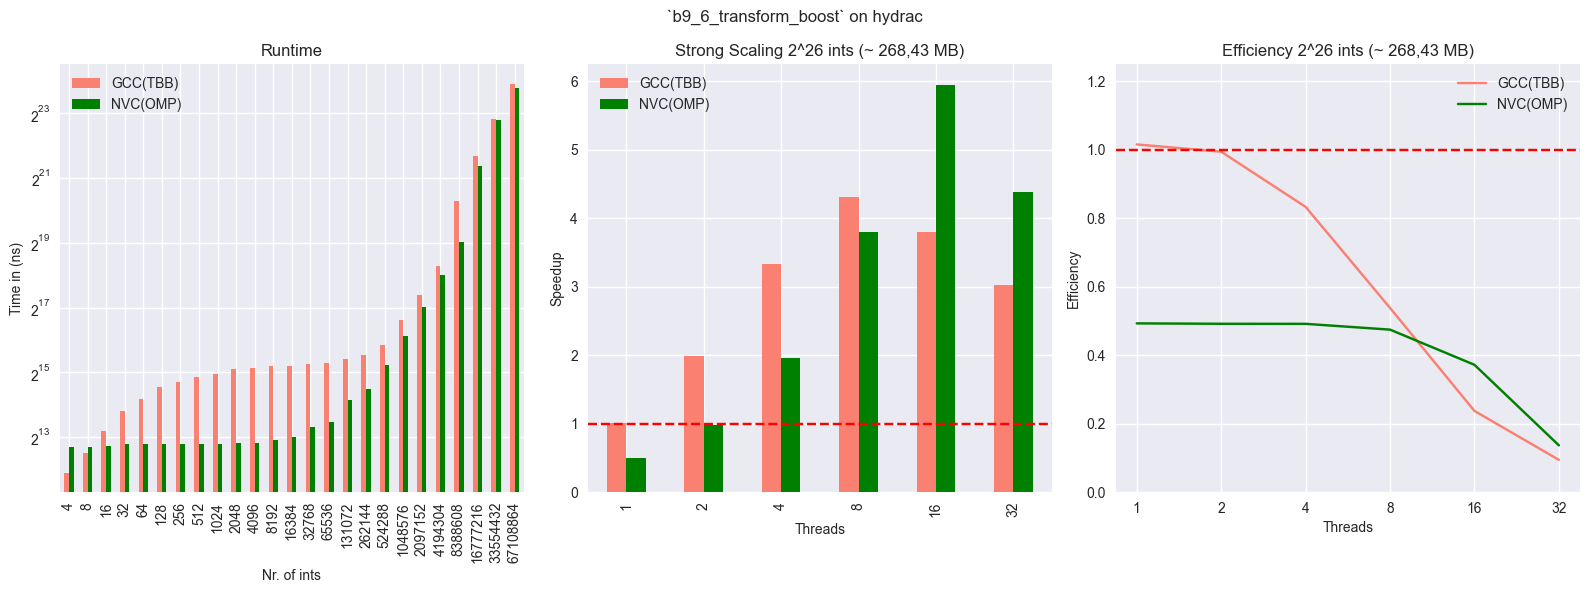

In [40]:
# graphs 

### Total graphs

fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 6))


# plot runtime
ax_1 = b9_6_transform_boost_time_merged.plot(kind='bar',x='n',align='center',color=[GCC_TBB_COLOR,NVC_OMP_COLOR], ax=axes[0])

ax_1.set_ylabel('Time in (ns)')
ax_1.set_xlabel('Nr. of ints')
ax_1.set_title('Runtime')
ax_1.set_yscale('log',base=2)


# plot strong scaling
ax_2 = b9_6_transform_boost_strong_scaling_merged.plot(kind='bar',
                                                                       x='threads',
                                                                       align='center',
                                                                       color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                                       ax=axes[1]
                                                                       )

# adding horizontal line where there is speedup
ax_2.axhline(y=1, color='r', linestyle='--')

#ax_2.set_ylim(0,3)
ax_2.set_ylabel('Speedup')
ax_2.set_xlabel('Threads')
ax_2.set_title('Strong Scaling 2^26 ints (~ 268,43 MB)')






# plot efficiency
ax_3 = b9_6_transform_boost_efficiency.plot(x='threads',
                                                            color=[GCC_TBB_COLOR,NVC_OMP_COLOR],
                                                            ax=axes[2]
                                                            )

# adding horizontal line where there is speedup
ax_3.axhline(y=1, color='r', linestyle='--')

ax_3.set_ylim(0,1.25)

ax_3.set_xscale('log', base=2)
current_values = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])

ax_3.set_ylabel('Efficiency')
ax_3.set_xlabel('Threads')
ax_3.set_title('Efficiency 2^26 ints (~ 268,43 MB)')


fig.suptitle("`b9_6_transform_boost` on hydrac")

fig.tight_layout()

plot("`b9_6_transform_boost` hydrac")

######################## DIVIDER ########################

## Performance Portability Calculation (Inter Compiler)

TODO

In [41]:
# calc pp_metrics

def calc_pp(data_points:List[int]) -> int:
    min_val = min(data_points)
    return len(data_points) / sum([1/(min_val/val) for val in data_points])

compilers = ['GCC(TBB)','NVC(OMP)']

pp_df = pd.DataFrame(columns=['name','GCC(TBB)','NVC(OMP)','PP'])


data_fields = [
    ('b9_1_transform_baseline',b9_1_transform_baseline_time_merged),
    ('b9_2_transform_old_iota',b9_2_transform_old_iota_time_merged),
    ('b9_3_transform_views_iota',b9_3_transform_views_iota_time_merged),
    ('b9_5_transform_custom_iterator',b9_5_transform_custom_iterator_time_merged),
    ('b9_6_transform_boost',b9_6_transform_boost_time_merged),
]

for data in data_fields:

    entry_dict = {
        'name': [data[0]],
    }

    vals = []

    for comp in compilers:
        current_val = int(data[1].iloc[-1][comp])
        entry_dict[comp] = [current_val]

        vals.append(current_val)

    entry_dict['PP'] = calc_pp(vals)

    other_df = pd.DataFrame.from_dict(entry_dict)
    pp_df = pd.concat([pp_df,other_df],ignore_index=True)


pp_df['INTERPRET'] = np.where(pp_df['PP']>0.85, 'GOOD', 'BAD')

pp_df['GCC(TBB)'] = pp_df['GCC(TBB)'].astype('int')
pp_df['NVC(OMP)'] = pp_df['NVC(OMP)'].astype('int')

pp_df


,name,GCC(TBB),NVC(OMP),PP,INTERPRET
0,b9_1_transform_baseline,16540200,14164400,0.922624,GOOD
1,b9_2_transform_old_iota,246859000,272346000,0.950911,GOOD
2,b9_3_transform_views_iota,47544800,15150200,0.483299,BAD
3,b9_5_transform_custom_iterator,16597100,14366100,0.927947,GOOD
4,b9_6_transform_boost,15892300,14598200,0.957557,GOOD


## Runtime difference between types

In [42]:
print('========= GCC(TBB) =========')

print('= ALL')
all_gcc_tbb = pp_df['GCC(TBB)']

print('\tStddev:',all_gcc_tbb.std())
print('\tPerformance Portability between types of indices:',calc_pp(all_gcc_tbb.tolist()))

print()
print('= ONLY EFFICIENT')
only_efficient = pp_df[pp_df['name'] != 'b9_2_transform_old_iota']['GCC(TBB)']

print('\tStddev:',only_efficient.std())
print('\tPerformance Portability between types of indices:',calc_pp(only_efficient.tolist()))



========= GCC(TBB) =========
= ALL
	Stddev: 100513905.73531108
	Performance Portability between types of indices: 0.2313738267739829

= ONLY EFFICIENT
	Stddev: 15604074.969272181
	Performance Portability between types of indices: 0.6582406931857718


In [43]:
print('========= NVC(OMP) =========')

print('= ALL')
all_gcc_tbb = pp_df['NVC(OMP)']

print('\tStddev:',all_gcc_tbb.std())
print('\tPerformance Portability between types of indices:',calc_pp(all_gcc_tbb.tolist()))

print()
print('= ONLY EFFICIENT')
only_efficient = pp_df[pp_df['name'] != 'b9_2_transform_old_iota']['NVC(OMP)']

print('\tStddev:',only_efficient.std())
print('\tPerformance Portability between types of indices:',calc_pp(only_efficient.tolist()))


========= NVC(OMP) =========
= ALL
	Stddev: 115281644.11111598
	Performance Portability between types of indices: 0.21420649200952502

= ONLY EFFICIENT
	Stddev: 425642.0826234173
	Performance Portability between types of indices: 0.9721803259841899


## Findings for H8

### XXX

### General


### GPU Findings


### Hypothesis Findings


